In [ ]:
# import packages 
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from scipy.interpolate import interp1d
%matplotlib inline

# define your own folder paths and names
project_path = os.getcwd()
input_folder = os.path.join(project_path,'pv_data','raw')
output_folder = os.path.join(project_path,'pv_data')

# file path
pv_data_raw_path = os.path.join(input_folder,'2018_pv_out.csv')

# Operating parameter
start_date = datetime.datetime(2018,9,25)
end_date = datetime.datetime(2018,10,5)

## 1. Read raw data from excel file

In [ ]:
# load raw data
pv_data_raw_df = pd.read_csv(pv_data_raw_path)

# modify the time format to datetime
pv_data_df = pd.DataFrame()
pv_data_df["Time"] = pv_data_raw_df["Date"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S"))
pv_data_df["PV_output_kw"] = pv_data_raw_df["Huang_E4102_kW"]

# select sample from starting time
pv_data_df = pv_data_df[(pv_data_df['Time']>=start_date) & (pv_data_df['Time']<=end_date)]

# reset index to starting from 0 and drop the old index
pv_data_df.reset_index(drop=True, inplace=True)
pv_data_df = pv_data_df.set_index('Time')

In [ ]:
pv_data_df

,PV_output_kw
Time,
2018-09-25 00:00:00,-0.083698
2018-09-25 00:01:00,-0.083520
2018-09-25 00:02:00,-0.084080
2018-09-25 00:03:00,-0.084793
2018-09-25 00:04:00,-0.084585
...,...
2018-10-04 23:56:00,-0.084665
2018-10-04 23:57:00,-0.084592
2018-10-04 23:58:00,-0.084583


## 2. PV data interpolation

In [ ]:
def interpaverage(record_times,record_outputs):
    # Generate interpolation function with interp1d
    start_time_dt = record_times[0]
    start_time_str = datetime.datetime.strftime(start_time_dt,"%Y-%m-%dT%H:%M:%S")
    record_times = record_times.astype('datetime64[s]')
    record_times_elapsed = (record_times - np.datetime64(start_time_str)).astype('int')
    f = interp1d(record_times_elapsed, record_outputs)

    # Interpolating to every 10 seconds 
    int_times_elapsed = np.arange(0, record_times_elapsed[-1], 10)
    int_outputs = f(int_times_elapsed)
    int_datetimes = start_time_dt+int_times_elapsed*datetime.timedelta(seconds=10)
    
    # Store the interpolated RAW data into a pd series
    #pv_output_raw_int = pd.Series(int_outputs, index = int_datetimes)
    pv_output_10s_int = pd.Series(int_outputs, index = int_datetimes) 

    #### we do not need to do rolling average anymore, as the data provided is the minutely average data ####
    # rolling average every sixty points. Store in center label. Drop NA at start and finish
    #pv_output_ave = pv_output_raw_int.rolling(window = 60, center = True).mean().dropna()
    
    # Check the correct number of entries has been dropped
    #assert pv_output_ave.size == pv_output_raw_int.size - 59

    # Store to hard drive
    #pv_output_10s_int = pv_output_ave.resample('10S').first()

    # Assert all index is 10s*N
    assert np.sum((pv_output_10s_int.index.second % 10).values) == 0
    
    return pv_output_10s_int

In [ ]:
record_times = np.asarray([time.to_pydatetime() for time in pv_data_df.index])
record_outputs = pv_data_df['PV_output_kw'].values

print("record_times.shape: ", record_times.shape)
print("record_outputs.shape: ", record_outputs.shape)

record_times.shape:  (14401,)
record_outputs.shape:  (14401,)


In [ ]:
record_times

array([datetime.datetime(2018, 9, 25, 0, 0),
       datetime.datetime(2018, 9, 25, 0, 1),
       datetime.datetime(2018, 9, 25, 0, 2), ...,
       datetime.datetime(2018, 10, 4, 23, 58),
       datetime.datetime(2018, 10, 4, 23, 59),
       datetime.datetime(2018, 10, 5, 0, 0)], dtype=object)

In [ ]:
record_outputs

array([-0.08369778, -0.08352031, -0.08407971, ..., -0.08458262,
       -0.08415516, -0.08488338])

In [ ]:
pv_output_10s_int = interpaverage(record_times,record_outputs)
pv_output_10s_int

2018-09-25 00:00:30   -0.083611
2018-09-25 00:00:40   -0.083590
2018-09-25 00:00:50   -0.083590
2018-09-25 00:01:00   -0.083611
2018-09-25 00:01:10   -0.083652
                         ...   
2018-10-04 23:58:50   -0.084291
2018-10-04 23:59:00   -0.084298
2018-10-04 23:59:10   -0.084338
2018-10-04 23:59:20   -0.084409
2018-10-04 23:59:30   -0.084513
Freq: 10S, Length: 86395, dtype: float64

## 3. Plot PV profile for everyday: Visual inspection of invalid days 

plotting for date 20180925


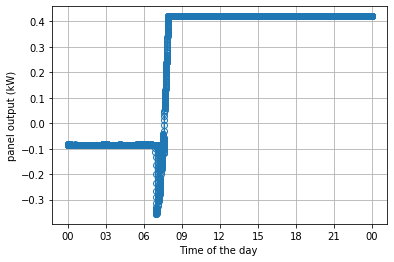

plotting for date 20180926


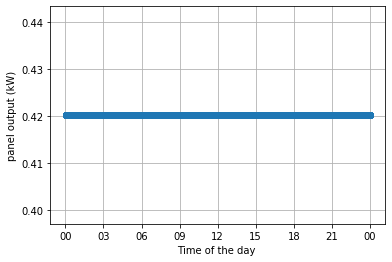

plotting for date 20180927


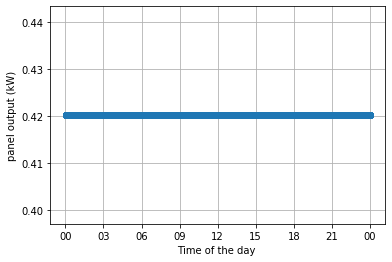

plotting for date 20180928


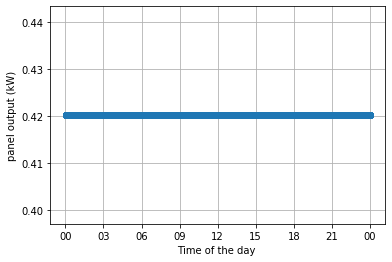

plotting for date 20180929


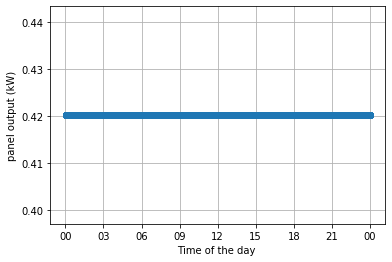

plotting for date 20180930


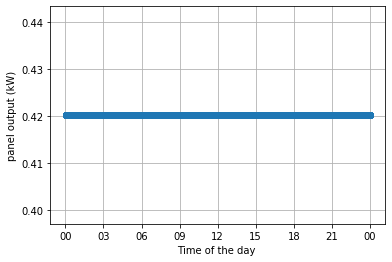

plotting for date 20181001


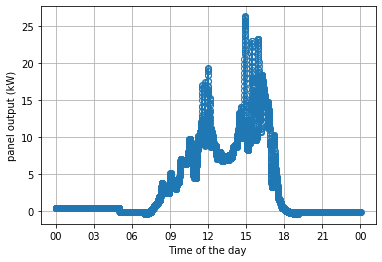

plotting for date 20181002


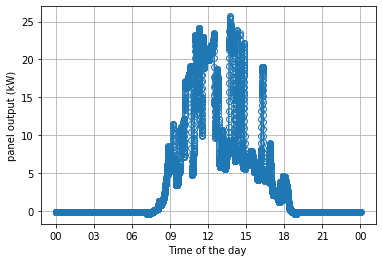

plotting for date 20181003


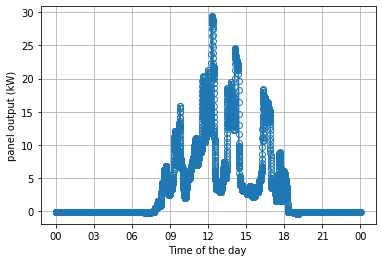

plotting for date 20181004


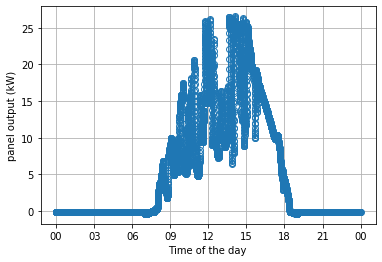

In [ ]:
#  Step through the PV_data day by day 
xfmt = mdates.DateFormatter('%H')
for date in pd.date_range(start = pv_output_10s_int.index[0], end = pv_output_10s_int.index[-1],
                         freq = '1D', closed = 'left'):
    hours_xaxis = pv_output_10s_int.loc[date:date+datetime.timedelta(days = 1)].index
    pv_one_day = pv_output_10s_int.loc[date:date+datetime.timedelta(days = 1)].values
    f, ax = plt.subplots()
    print('plotting for date',date.strftime('%Y%m%d'))
    ax.plot(hours_xaxis,pv_one_day,'-o',markerfacecolor='None')
    ax.grid(True)
    ax.set_xlabel('Time of the day ')
    ax.set_ylabel('panel output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    plt.show()

In [ ]:
# define invalide dates based on the curves above for sanity check
# the data is defined as invalid if the PV panel output interpolated from two points more than an hour apart
# end date is not inclusive, for the example the invalid days are [2018-9-25,2018-10-1), essentially [2018-9-25, 2018-09-30]
invalid_dates = {'start':[datetime.datetime(2018,9,25)],
                  'end':[datetime.datetime(2018,10,1)]}

## 4. Filter for invalid data

### 4.1 Missing record filter

In [ ]:
# Calculate raw record interval
record_interval = record_times[1:] - record_times[:-1]

# Consider interval > 1 hour as invalid (i.e., linear interpolation for > 1 hour is invalid)
record_invalid_start = record_times[:-1][record_interval > np.timedelta64(1,'h')]
record_invalid_end = record_times[1:][record_interval > np.timedelta64(1,'h')]

missing_mask = pd.Series(False, index = pv_output_10s_int.index)

for start,end in zip(record_invalid_start, record_invalid_end):
    missing_mask.loc[start:end] = True

In [ ]:
# check the invalid time stamps
for start, end in zip(record_invalid_start,record_invalid_end):
    print(start, end)

### 4.2 Night filter (PV_output<0)

In [ ]:
pv_output_valid = pv_output_10s_int[(~missing_mask) & (pv_output_10s_int>0)]
pv_output_valid

2018-10-01 07:28:50    0.006620
2018-10-01 07:29:00    0.023463
2018-10-01 07:29:10    0.037405
2018-10-01 07:29:20    0.048443
2018-10-01 07:29:30    0.056579
                         ...   
2018-10-04 18:23:40    0.148296
2018-10-04 18:23:50    0.101908
2018-10-04 18:24:00    0.061922
2018-10-04 18:24:10    0.028340
2018-10-04 18:24:20    0.001160
Length: 15448, dtype: float64

plotting for date 20181001


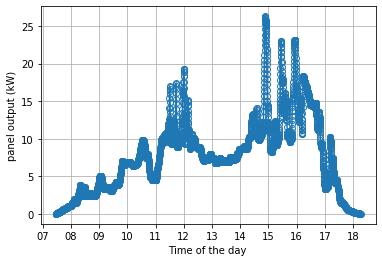

plotting for date 20181002


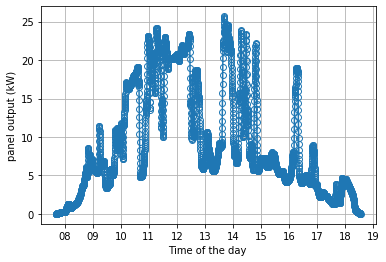

plotting for date 20181003


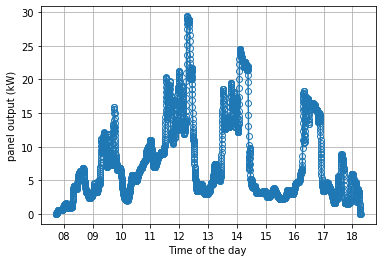

plotting for date 20181004


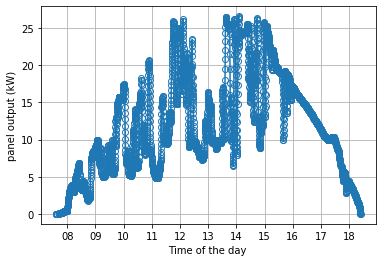

In [ ]:
#  Inspect again for the valid data
xfmt = mdates.DateFormatter('%H')
all_times = pv_output_valid.index
all_pv = pv_output_valid.values
all_dates = np.asarray([times.date() for times in all_times])
unique_dates = np.unique(all_dates)

for date in unique_dates:
    idx = np.where(all_dates==date)[0]
    time_one_day = all_times[idx]
    pv_one_day = all_pv[idx]
    f, ax = plt.subplots()
    print('plotting for date',date.strftime('%Y-%m-%d'))
    ax.plot(time_one_day,pv_one_day,'-o',markerfacecolor='None')
    ax.grid(True)
    ax.set_xlabel('Time of the day')
    ax.set_ylabel('panel output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    plt.show()

In [ ]:
# Store the PV output record. Freq = 10s
pv_output_valid.to_pickle(os.path.join(output_folder,'pv_output_valid.pkl'))